In [42]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import seaborn as sns 
import matplotlib 
import matplotlib.pyplot as plt 

from keras.preprocessing.image import (ImageDataGenerator, 
                                       img_to_array, 
                                       array_to_img, 
                                       load_img)

from sklearn.model_selection import train_test_split

from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             accuracy_score, 
                             f1_score, 
                             roc_auc_score)

import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten

from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping,LearningRateScheduler


from keras import backend as K
K.clear_session()

from sklearn.utils import shuffle



In [43]:
from config import Config


config  = Config()

IMAGE_SIZE=(config.image_width, config.image_height)
IMAGE_CHANNELS= config.number_of_channels

In [44]:
train_dir = config.train_data_dir
test_dir = config.test_data_dir

In [45]:
def label(path): 
    return [file.split('_')[0] for file in os.listdir(path)]

def filename(path):
    return [file for file in os.listdir(path)]

train_names = filename(train_dir) 
test_names = filename(test_dir)
train_class = label(train_dir)


In [46]:
test_class = label(test_dir)
test_df = pd.DataFrame({'filename': test_names , 'category': test_class})


In [47]:
train_df = pd.DataFrame({ 'filename': train_names, 'category': train_class})


In [48]:
train_df

,filename,category
0,Bar_image1652.PNG,Bar
1,Bar_image3444.PNG,Bar
2,Pie_image2144.PNG,Pie
3,Pie_image202.PNG,Pie
4,Bar_image459.PNG,Bar
...,...,...
7995,Pie_image3368.PNG,Pie
7996,Pie_image3792.PNG,Pie
7997,Bar_image2460.PNG,Bar
7998,Bar_image297.PNG,Bar


In [7]:
valid_df, train_df = train_test_split(train_df, test_size = (6/8))

In [8]:
train_df

,filename,category
7478,Pie_image288.PNG,Pie
14337,Pie_image22583.PNG,Pie
56582,Pie_image23924.PNG,Pie
61993,Pie_image37917.PNG,Pie
32330,Pie_image33689.PNG,Pie
...,...,...
54524,Bar_image18083.PNG,Bar
26052,Pie_image30591.PNG,Pie
21410,Bar_image6061.PNG,Bar
1611,Bar_image20649.PNG,Bar


In [9]:
batch_size = 16


In [10]:
train_map = ImageDataGenerator()
valid_map = ImageDataGenerator()
test_map =  ImageDataGenerator()

In [11]:
train_data = train_map.flow_from_dataframe(
            train_df,train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = IMAGE_SIZE,
            batch_size = batch_size,
            class_mode = 'categorical')

valid_data = valid_map.flow_from_dataframe(
             valid_df, train_dir,
             x_col = 'filename',
             y_col = 'category',
             target_size = IMAGE_SIZE,
             batch_size = batch_size,
             class_mode = 'categorical')


test_data = test_map.flow_from_dataframe(
             test_df, train_dir,
             x_col = 'filename',
             y_col = None,
             target_size = IMAGE_SIZE,
             batch_size = batch_size,
             class_mode = None,
             shuffle = False)

Found 60000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames.


In [12]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(config.image_width, config.image_height, config.number_of_channels
                                                            )))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0

In [13]:
loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate= 0.001)
metrics = ['accuracy']

train_images = train_df.shape[0]
valid_images = valid_df.shape[0]
model.compile(loss = loss, optimizer = opt, metrics = metrics)


# fitting the model for training dataset
history = model.fit(train_data, epochs = 50,
                          validation_data = valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size)

Epoch 1/50
3750/3750 [==============================] - 90s 22ms/step - loss: 0.0110 - accuracy: 0.9969 - val_loss: 7.9615e-06 - val_accuracy: 1.0000
Epoch 2/50
3750/3750 [==============================] - 80s 21ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0387 - val_accuracy: 0.9988
Epoch 3/50
3750/3750 [==============================] - 80s 21ms/step - loss: 2.7751e-04 - accuracy: 0.9999 - val_loss: 5.5162e-04 - val_accuracy: 0.9999
Epoch 4/50
3750/3750 [==============================] - 80s 21ms/step - loss: 8.7391e-04 - accuracy: 0.9999 - val_loss: 7.6737e-05 - val_accuracy: 0.9999
Epoch 5/50
3750/3750 [==============================] - 81s 22ms/step - loss: 6.3766e-04 - accuracy: 0.9999 - val_loss: 0.0546 - val_accuracy: 0.9993
Epoch 6/50
3750/3750 [==============================] - 80s 21ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.1277 - val_accuracy: 0.9990
Epoch 7/50
3750/3750 [==============================] - 80s 21ms/step - loss: 2.6041e-04 - accuracy:

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

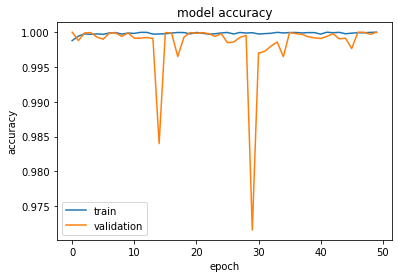

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()


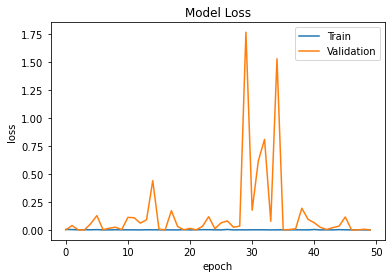

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [27]:
pred = model.predict(test_data)
test_df['pred'] = np.argmax(pred, axis = -1)
labels = dict((v,k) for k,v in train_data.class_indices.items())

test_df['pred'] = test_df['pred'].map(labels)

In [33]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):


    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False


    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('#f5f6f6')
    sns.heatmap(cf,annot=box_labels,fmt="",linewidths = 1,square = True,linecolor= '#f5f6f6',
                cmap=cmap,cbar=cbar,
                xticklabels=categories,
                yticklabels=categories,)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' )
    else:
        plt.xlabel(stats_text)
    


In [34]:
test_df

,filename,category,pred
0,Pie_image5233.PNG,Pie,Pie
1,Pie_image8541.PNG,Pie,Pie
2,Pie_image5616.PNG,Pie,Pie
3,Pie_image8391.PNG,Pie,Pie
4,Bar_image1652.PNG,Bar,Bar
...,...,...,...
19995,Bar_image1511.PNG,Bar,Bar
19996,Pie_image6867.PNG,Pie,Pie
19997,Pie_image8647.PNG,Pie,Pie
19998,Bar_image6253.PNG,Bar,Bar


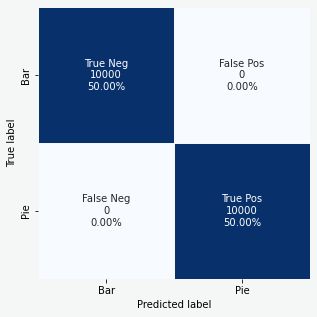

In [35]:
vani_cf_matrix = confusion_matrix(test_df['category'],test_df['pred'])

labels = [ 'True Neg','False Pos','False Neg','True Pos']
categories = ['Bar', 'Pie']
make_confusion_matrix(vani_cf_matrix,figsize = (10,5),
                      group_names=labels,cbar = False,
                      categories=categories, 
                     )


plt.gcf().show()